Manel Azoun 84966753\
Emma Gjøen 74324823\
Srijan Ravisankar 86992831\
Thayantha Sritharan 38664397

# Data Science Project - Final Report

## Introduction
This report is a group project in the DSCI 100 course at UBC. For the project we were given two real datasets from a research group at UBC who are interested in understanding how people play videogames. To do the research, they drift a server running the game MineCraft and record sessions of players. Minecraft is like a creative playground in a virtual world where you can build structures, explore, and have adventures. Players are free to explore the game because there aren’t any set rules or goals so they have the freedom to build whatever they can imagine, and create their own fun. The research group wants to manage its server resources according to the demands, and they want to recruit more players to collect data on. In order to recruit more players, the stakeholder want to know which "kinds" of players are most likely to contribute a large amount of data, so that they can be targeted in the recruiting efforts. To help them with this, we have stated the following question below to do analysis on.

---

### Question

**What are the kinds of players, according to "experience", "gender" and "age", are most likely to be a "contributor"of a large amount of data of one hour or more?**
### I do not know if it is clear enough
**Which types of players, based on 'experience,' 'age,' and 'gender,' are most likely to contribute more data (defined as playing one hour or more) to allow the organization to focus on recruiting these individuals?**

---

### Data Description
We were given two datasets: "Players" and "Sessions". The Players dataset has one row for each individual player. The Sessions dataset has one row for each played session. One player can be part of several sessions. Due to the choice of explanatory and response variables in our questions, we only need to use the Players dataset.

#### Players Dataset:
196 observations, 9 variables

- `experience` (chr): Gaming experience of the player                      
- `subscribe`(lgl): Whether the player has subscribed or not            
- `hashedEmail`(chr): Encrypted 64-character hashcode of player's email ID
- `played_hours`(dbl): Number of hours an individual player played         
- `name`(chr): Name of the player                                  
- `gender`(chr): Gender of the player                                
- `age`(dbl): Age of the player                                   
- `individualId`(lgl): ID of the player (empty for all examples)                                    
- `organizationName`(lgl): Organization to which the player belongs (empty for all examples)


## Methods & Results

In this section we will load the dataset, wrangle it to a tidy format and perform our analysis. We will reason the steps taken along the way.

In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [5]:
# Reading data
players_data <- read_csv("https://raw.githubusercontent.com/EmmaGjoen/data_science_group_project/refs/heads/main/players.csv")
head(players_data)

# Setting seed for reproducibility
set.seed(123)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


### Why One hour is chosen as the cutoff?

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


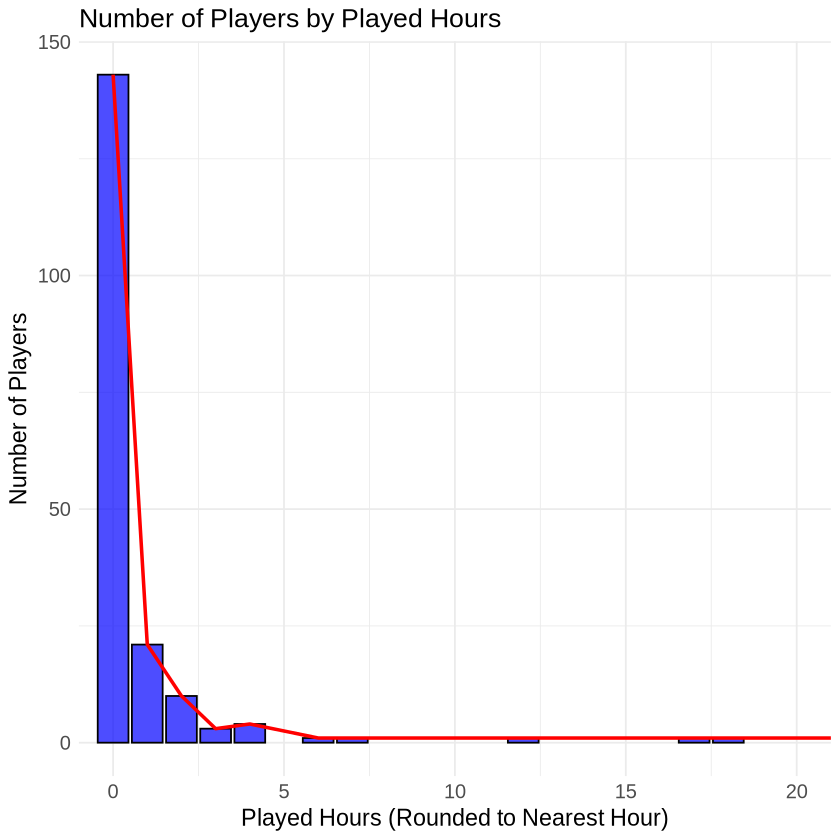

In [6]:
hourly_data <- players_data |>
  mutate(rounded_hours = round(played_hours)) |>
  group_by(rounded_hours) |>
  summarise(number_of_players = n())


ggplot(hourly_data, aes(x = rounded_hours, y = number_of_players)) +
  geom_bar(stat = "identity", fill = "blue", color = "black", alpha = 0.7) +
  geom_line(aes(x = rounded_hours, y = number_of_players), color = "red", size = 1) + 
  labs(title = "Number of Players by Played Hours",
       x = "Played Hours (Rounded to Nearest Hour)",
       y = "Number of Players") +
  coord_cartesian(xlim = c(0, 20)) +
  theme_minimal() +
  theme(plot.title = element_text(size = 16),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))


              

From the graph, we see that majority of players have played for fewer than one hour. This is evident from the bar chart, where the count of players between hour 0 and hour 1 significantly outweighs the counts in subsequent hours.

Therefore, the cutoff is based on a clear observation of the distribution. By analyzing the bar chart, we can see that the frequency drops sharply after 1 hour (denoted by the black horizontal line), indicating a distinct shift in players' behavior/action. We can infer that players who exceed this threshold are likely to be more committed or regular users, and thus will contribute to the large amount of data.

This decision helps to create logical and interpretable groups such as contributors and non-contributors for analysis or intervention.

### Wrangling
We subtract the explanatory features stated in our question: `experience`, `gender` and `age`. Their datatypes are changed to better represent the values of the features: `contributer` and `experience`consists of a limited amount of categories and `age` is limited to being a whole number. The response variable`contributer` are made based on the amount of played hours. The data is still on a tidy format, where each row represents an individual player.

We created a new column named `age_range` from the `age` column to identify patterns across different age groups. The`age_range`column will have five subcategories: 8–18, 19–30, 31–45, 46–60, and 60+. This will help in recognizing any patterns based on age.

In [19]:
# Wrangling data
wrangled_players_data <- players_data |>
  mutate(
    contributor = factor(if_else(played_hours >= 0.2, "Yes", "No")),
    experience = as.factor(experience),
    gender = as.factor(gender),
    age = as.double(age),
#      age_range = cut(age,
#                        breaks = c(0, 18, 30, 45, 60, Inf),
#                        labels = c("8-18", "19-30", "31-45", "46-60", "60+"),
#                        right = FALSE)
  ) |>
  select(experience, gender, age, contributor)
wrangled_players_data

experience,gender,age,contributor
<fct>,<fct>,<dbl>,<fct>
Pro,Male,9,Yes
Veteran,Male,17,Yes
Veteran,Male,17,No
⋮,⋮,⋮,⋮
Amateur,Prefer not to say,17,No
Amateur,Male,17,Yes
Pro,Other,91,Yes


### Summarizations and visualizations
For `experience` and `gender` we count the number of players in each category as this gives an intuition for the distrubution of the players. For `age`we see that most players are around 19- 21, but that there are a few outliers that can affect our analysis.

In [34]:
# Summarizing data
#distribution of exprience
experience_distirbution <- wrangled_players_data |>
                              group_by(experience) |>
                              summarise(count = n())
experience_distirbution
#Distribution of gender
gender_distribution <- wrangled_players_data|>
                          count(gender) |>
                          slice_max(gender, n = 6)
gender_distribution

#Demographics of age
age_demo <- wrangled_players_data |>
                      summarise(
                        min_age = min(age),
                        max_age = max(age),
                        mean_age = mean(age),
                        median_age = median(age)
                      )
age_demo

#Distribution of top ages
age_distribution <- wrangled_players_data |>
                        group_by(age) |>
                        summarise(count = n()) |>
                        slice_max(count, n = 6)
age_distribution

# proportion of contributor vs. non-contributors
contributor_prop <- wrangled_players_data |>
                          count(contributor) |>
                          mutate(proportion = n / sum(n))
contributor_prop

experience,count
<fct>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


gender,n
<fct>,<int>
Two-Spirited,6
Prefer not to say,11
Other,1
Non-binary,15
Male,124
Female,37


min_age,max_age,mean_age,median_age
<dbl>,<dbl>,<dbl>,<dbl>
8,99,21.28061,19


age,count
<dbl>,<int>
17,75
21,18
22,15
20,14
23,13
24,10


contributor,n,proportion
<fct>,<int>,<dbl>
No,119,0.6071429
Yes,77,0.3928571


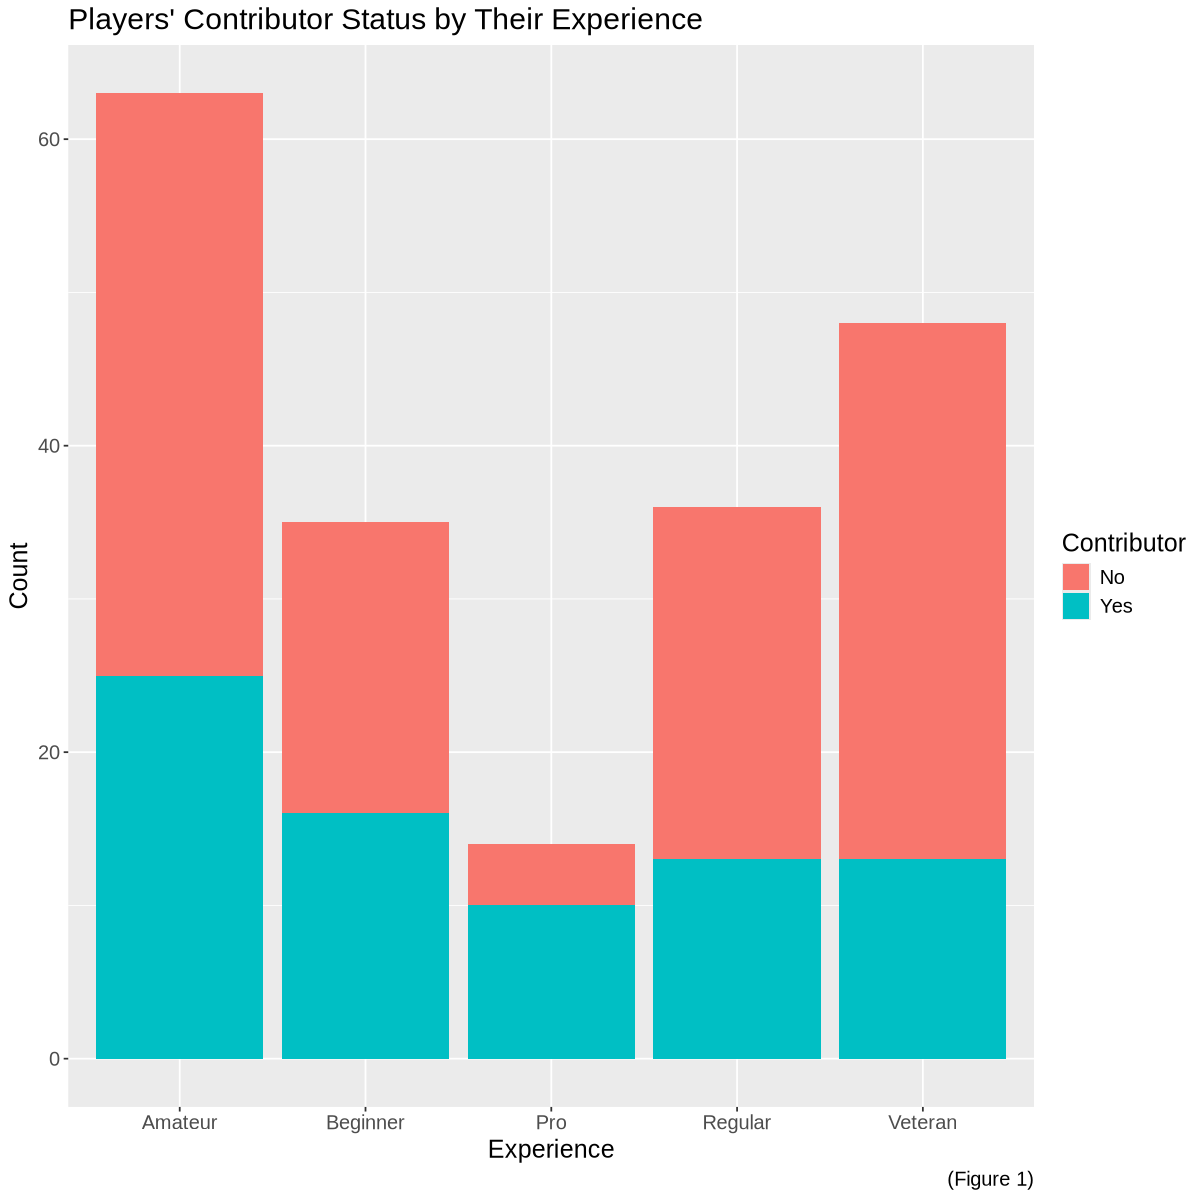

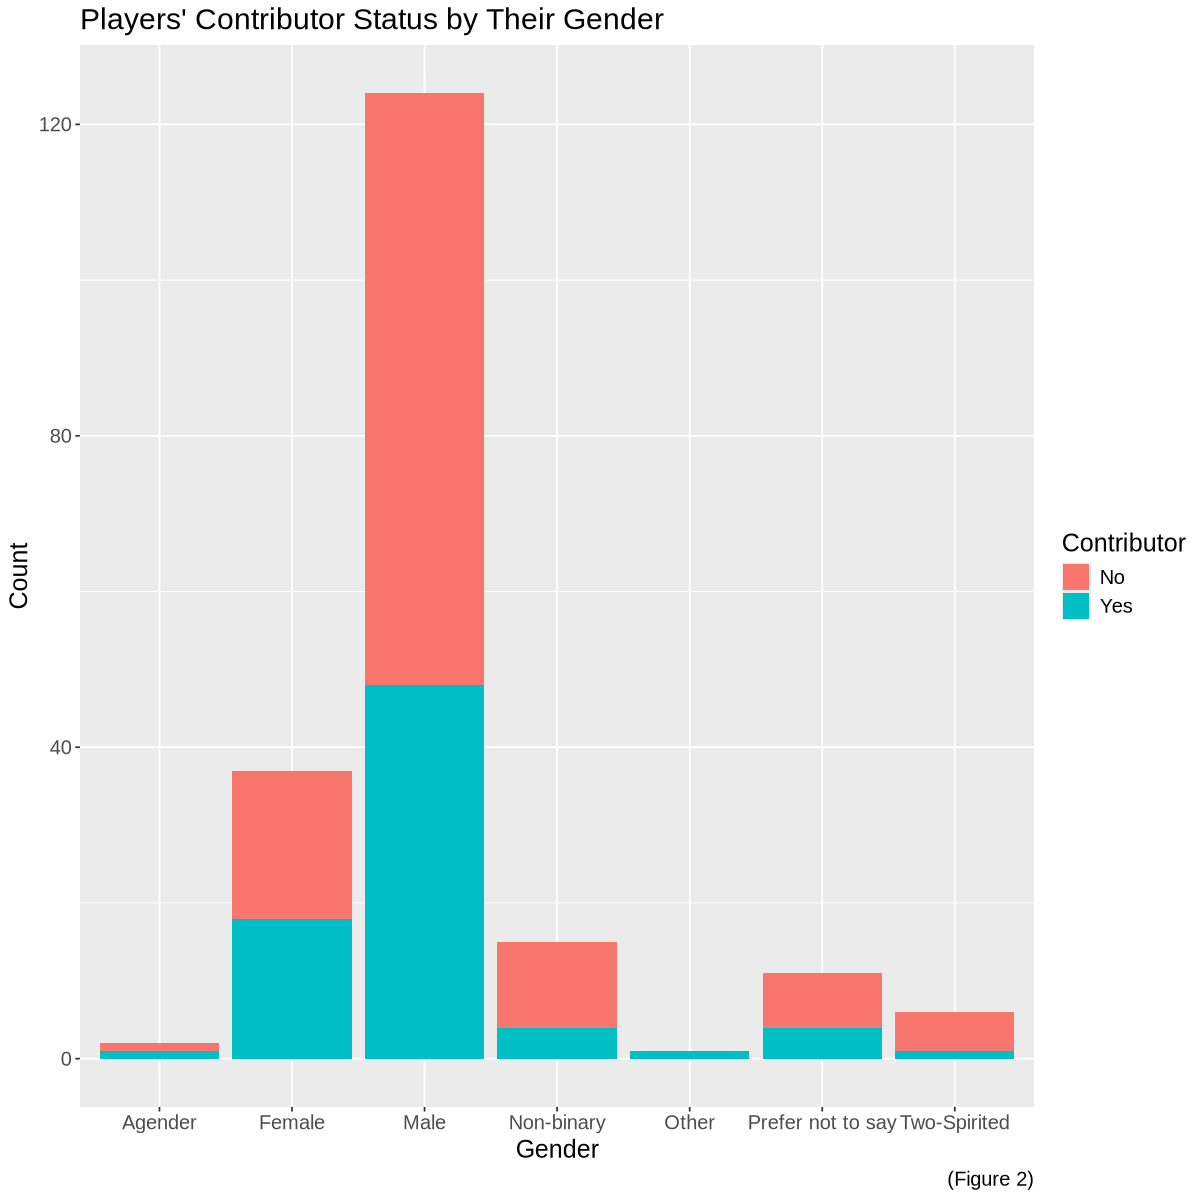

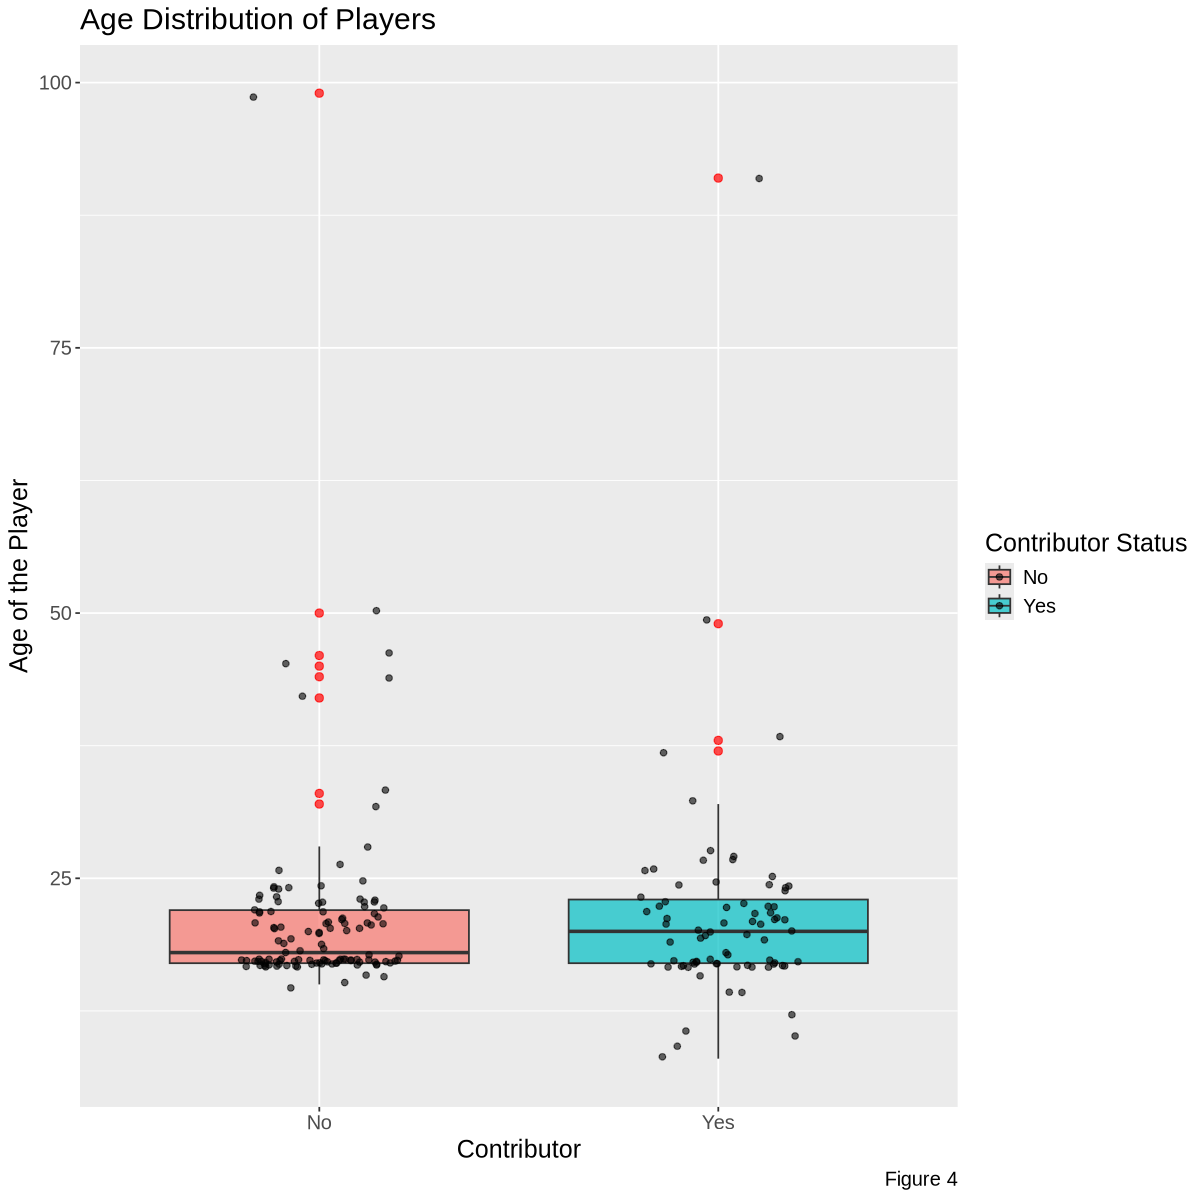

In [36]:
# Visualizing data
options(repr.plot.width = 10, repr.plot.height = 10)

#Bar graph to decipher players' contributor status based on their experience
experience_plot <- ggplot(wrangled_players_data, aes(x = experience, fill = factor(contributor))) +
                        geom_bar(position = "stack") +
                        labs(
                            title = "Players' Contributor Status by Their Experience",
                            x = "Experience",
                            y = "Count",
                            fill = "Contributor",
                            caption = "(Figure 1)"
                            ) + 
                        theme(text = element_text(size = 15))
experience_plot

#gender_pplot <- ggplot(wrangled_players_data, aes(x = gender, fill = factor(contributor))) +
#                    geom_bar(position = "fill") +
#                    labs(
#                        title = "Proportion of Contributors by Gender",
#                        x = "Gender",
#                        y = "Proportion",
#                        fill = "Contributor",
#                        caption = ("Figure 2")
#                    ) + 
#                    theme(text = element_text(size = 15),
#                         axis.text.x = element_text(angle = 45, hjust = 1))
#gender_pplot
### I think going with "count" proves why we need to exclude gender in our analysis
#### Gender will not be  used for further analysis and reasoning is given in the below cell

#Bar graph to decipher players' contributor status based on their gender
gender_plot <- ggplot(wrangled_players_data, aes(x = gender, fill = factor(contributor))) +
                    geom_bar(position = "stack") +
                    labs(
                        title = "Players' Contributor Status by Their Gender",
                        x = "Gender",
                        y = "Count",
                        fill = "Contributor",
                        caption = "(Figure 2)"
                    ) + 
                    theme(text = element_text(size = 15))
gender_plot

### DID THE PLOT WITH COUNT AND PROPORTION TO SEE ANY PATTERN
# ggplot(wrangled_players_data, aes(x = age_range, fill = factor(contributor))) +
#    geom_bar(position = "fill") +
#    labs(
#        title = "Proportion of Contributors by Age Range",
#        x = "Age Range ",
#        y = "Proportion",
#        fill = "Contributor",
#        caption = ("Figure 3")
#    ) + 
#    theme(text = element_text(size = 15),
#         axis.text.x = element_text(angle = 45, hjust = 1))

#Histogram to decipher players' contributor status based on their gender
# age_pplot <- ggplot(wrangled_players_data, aes(x = age_range, fill = factor(contributor))) +
#    geom_bar(position = "stack") +
#    labs(
#        title = "Number of Contributors by age_range",
#        x = "Age Range of players",
#        y = "Count",
#        fill = "Contributor",
#        caption = "(Figure 3)"
#    ) + 
#    theme(text = element_text(size = 15))
# age_pplot

#Box plot to decipher players' contributor status based on their age
age_plot <- ggplot(wrangled_players_data, aes(x = factor(contributor), y = age, fill = factor(contributor))) +
                geom_boxplot(alpha = 0.7, outlier.size = 2, outlier.color = "red") +
                geom_jitter(width = 0.2, size = 1.5, alpha = 0.6, color = "black") +
                labs(
                    title = "Age Distribution of Players",
                    x = "Contributor",
                    y = "Age of the Player",
                    fill = "Contributor Status",
                    caption = ("Figure 4")
                ) + 
                theme(text = element_text(size = 15))
age_plot

### need to remove it 
#ggplot(wrangled_players_data, aes(x = factor(contributor), fill = factor(contributor))) +
#    geom_bar(position = "stack", alpha = 0.8) +
#    facet_grid(gender ~ experience) +
#    labs(
#        title = "Contributors by Experience, Gender, and Status",
#        x = "Contributor Status (0 = No, 1 = Yes)",
#        y = "Count",
#        fill = "Contributor Status",
#        caption = ("Figure 5")
#    ) + 
#    theme(text = element_text(size = 15))



### REASON WE NEED TO EXCLUDE GENDER COLUMN IN OUR ANALYSIS
The gender column shows a highly imbalanced distribution:

The "Male" category dominates the dataset with 124 observations, followed by "Female" with 37.
Other categories, such as "Agender," "Other," and "Two-Spirited," have very small counts (e.g., 1–15), making it challenging to draw meaningful conclusions about these groups.
In addition, this might lead to biased interpretations especially if the small groups do not provide statistically significant insights.

### Data analysis
- 75% of the wrangled dataset is used for model training, and the remaining 25% for testing.
- The levels in the `experience`variable is replaced by numbers from 1-5 in order to scale and centre both the explanatory variables.
- Since the stated question is a binary classification problem, the KNN model is used to predict new data.

In [10]:
# # DELETE THIS PLOT BEFORE DELIVERY - is here to visualize the change of experience variable into numerical
# # plot <- wrangled_players_data |>
# #     ggplot(aes(x=age, y=experience, color = contributor)) +
# #     geom_point()
# # plot

# #This wrangling can be done earlier, is used to change wrangled_players_data into only numerical explanatory variables for scaling
# # numerical_players_data <- wrangled_players_data |>
# #     select(experience, age, contributor) |> #Do this at earlier stage when we decide to exclude gender
# #     mutate(experience = as.numeric(factor(experience, levels = c("Amateur", "Beginner", "Pro", "Regualar", "Veteran")))) |> 
# #     mutate(gender = as.numeric(factor(gender, levels = c("Agender", "Female", "Male", "Non-binary", "Other", "Prefer not to say", "Spirited")))) |>
# #     filter(!is.na(experience), !is.na(gender)) 

# # DELETE THIS PLOT BEFORE DELIVERY - is here to visualize the change of experience variable into numerical
# # plot_2 <- wrangled_players_data |>
# #     ggplot(aes(x=age, y=experience, color = factor(contributor))) +
# #     geom_point()
# # plot_2

# # Splitting Data 75/25
# players_split <- initial_split(wrangled_players_data, prop = 0.75, strata = contributor)
# players_train <- training(players_split)
# players_test <- testing(players_split)

# # Creating recipe
# # players_recipe <- recipe(contributor ~ experience + age, data = players_train) |>
# #     step_scale(all_numeric_predictors()) |>
# #     step_center(all_numeric_predictors())

# players_recipe <- recipe(contributor ~ experience + gender, data = players_train) |>
#     step_scale(all_numeric_predictors()) |>
#     step_center(all_numeric_predictors()) |>
#     step_dummy(all_nominal_predictors())

# # Defining KNN specification
# players_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#     set_engine("kknn") |>
#     set_mode("classification")

# Setting seed for reproducibility
set.seed(123)

test_data <- players_data |>
  mutate(
    contributor = factor(if_else(played_hours >= 1, "Yes", "No")),
    experience = as.factor(experience),
    gender = as.factor(gender),
    age = as.integer(age)
  ) |>
  select(experience, gender, age, contributor)

test_data

# Splitting Data
players_split <- initial_split(test_data, prop = 0.75, strata = contributor)
players_train <- training(players_split)
players_test <- testing(players_split)

# Creating recipe
players_recipe <- recipe(contributor ~ experience + gender + age, data = players_train) |>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors()) |>
    step_dummy(all_nominal_predictors())

# Defining KNN specification
players_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

experience,gender,age,contributor
<fct>,<fct>,<int>,<fct>
Pro,Male,9,Yes
Veteran,Male,17,Yes
Veteran,Male,17,No
⋮,⋮,⋮,⋮
Amateur,Prefer not to say,17,No
Amateur,Male,17,Yes
Pro,Other,91,No


### Tuning the classifier
 - 5-fold cross validation is used to choose the value of the K parameter. This way we have more data to evaulate the model on.
 - The dashed line in Figure 5 shows the best value of K

In [11]:
# # 5-fold cross validation
# players_5_folds <- vfold_cv(players_train, v = 5, strata = contributor)
# k_values <- tibble(neighbors = seq(1, 12, by = 2))

# # Tuning the model
# players_knn_results <- workflow() |>
#     add_recipe(players_recipe) |>
#     add_model(players_knn_spec) |>
#     tune_grid(resamples = players_5_folds, grid = k_values) |>
#     collect_metrics()

# # Extracting best k from results
# accuracies <- players_knn_results |> 
#     filter(.metric == "accuracy")

# #Choose the k that has the highest accuracy
# best_k <- accuracies |> 
#     arrange(desc(mean)) |> 
#     head(1) |> 
#     pull(neighbors)

# #Plot accuracy vs k-value
# # accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
# #     geom_point() +
# #     geom_line() +
# #     labs(x = "Number of Neighbors \n (K)",
# #          y = "Accuracy Estimate \n (after 5-fold cross validation)",
# #          title = "Estimated Accuracy vs. Number of Neighbours",
# #         caption = "(Figure 5)") +
# #     theme(text = element_text(size = 15)) + 
# #     geom_vline(xintercept = best_k, linetype = "dashed")

# # accuracy_vs_k

# Cross-validation folds
players_folds <- vfold_cv(players_train, v = 5, strata = contributor)
players_k_values <- tibble(neighbors = seq(1, 20, by = 2))

# Tuning the model
players_knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_knn_spec) |>
    tune_grid(resamples = players_folds, grid = players_k_values) |>
    collect_metrics()

# Extracting best k from results
accuracies <- players_knn_results |> 
    filter(.metric == "accuracy")

best_k <- accuracies |> 
    arrange(desc(mean)) |> 
    slice(1) |> 
    pull(neighbors)

### Evaluate on test-set
 - Using the defined parameters, the tuned model is fitted on the whole training dataset

In [12]:
# # Define KNN specification with best k
# final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
#     set_engine("kknn") |>
#     set_mode("classification")

# # Creating workflow with final specification
# knn_fit <- workflow() |>
#     add_recipe(players_recipe) |>
#     add_model(final_knn_spec) |>
#     fit(players_train)

# # Making predictions on the testing data
# test_predictions <- predict(knn_fit, new_data = players_test) |>
#     bind_cols(players_test)
# test_predictions

# Define KNN specification with best k
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Creating workflow with final specification
final_knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(final_knn_spec) |>
    fit(players_train)

# Making predictions on the testing data
test_predictions <- predict(final_knn_fit, new_data = players_test) |>
    bind_cols(players_test)
test_predictions
     

.pred_class,experience,gender,age,contributor
<fct>,<fct>,<fct>,<int>,<fct>
No,Veteran,Male,17,No
No,Amateur,Female,21,No
No,Regular,Male,21,No
⋮,⋮,⋮,⋮,⋮
No,Veteran,Male,17,No
No,Pro,Male,21,No
No,Amateur,Female,22,No


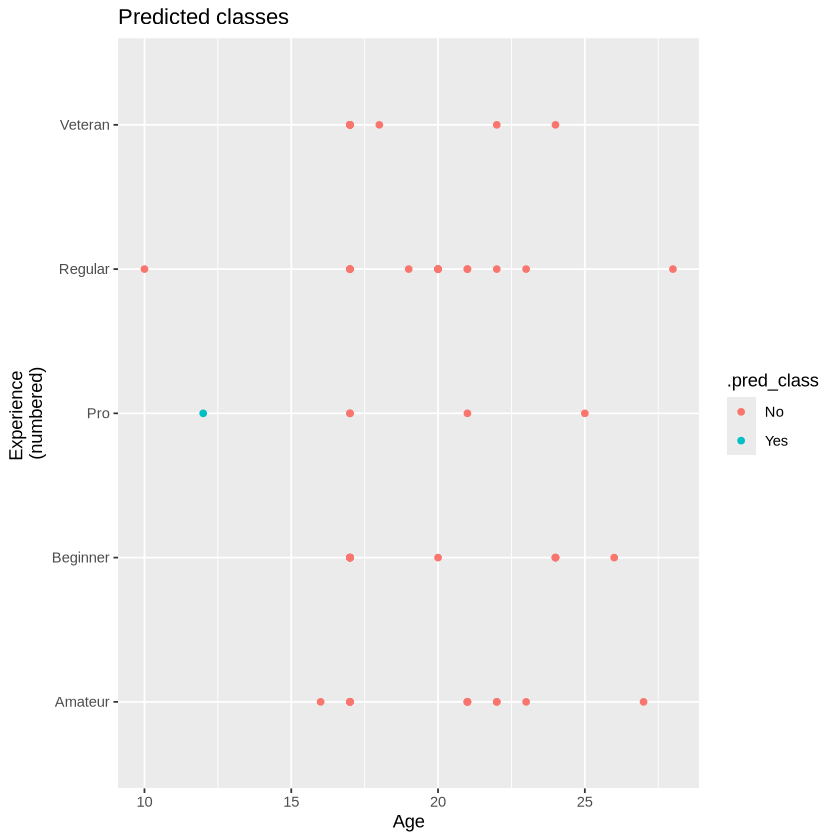

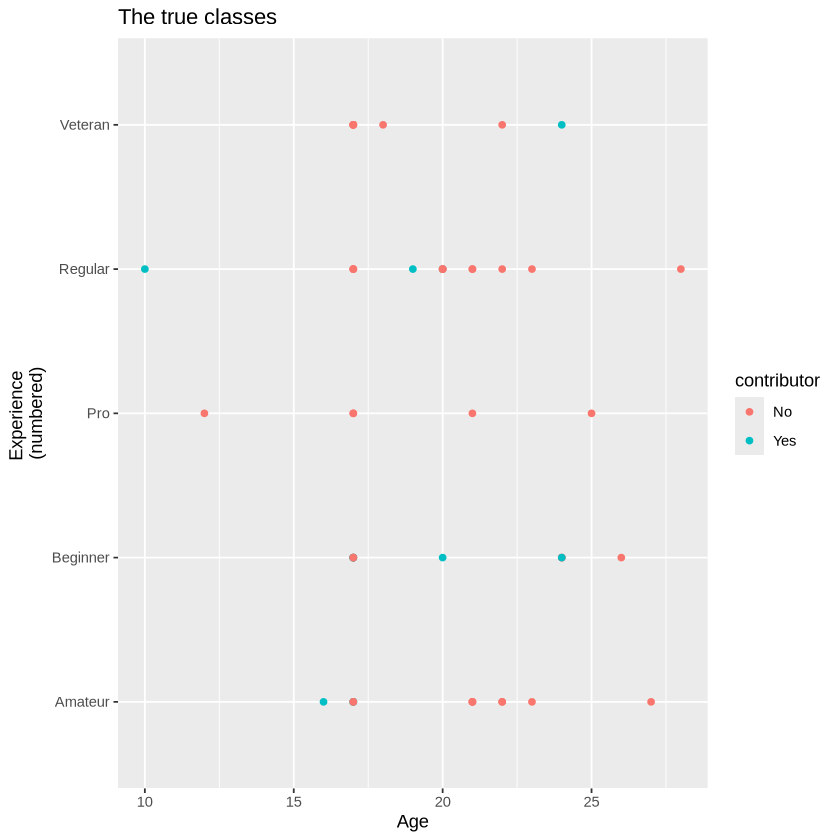

In [13]:
pred_plot <- test_predictions |>
    ggplot(aes(x=age, y=experience, color=.pred_class)) +
    geom_point() + 
    labs(x="Age",
         y="Experience \n(numbered)",
         title="Predicted classes")
pred_plot

true_plot <- test_predictions |>
    ggplot(aes(x=age, y=experience, color=contributor)) +
    geom_point() + 
    labs(x="Age",
         y="Experience \n(numbered)",
         title="The true classes")
true_plot

### Visualization of the model
- The knn-model is visualized with the (true or predicted?) points from the (scaled?) training data.
- The background colour shows the decision boundries according to the k nearest neighbours.

In [14]:
# use training data to define grid ranges
age_grid <- seq(
    min(players_train$age), 
    max(players_train$age), 
    length.out = 100
)
experience_grid <- seq(
    min(players_train$experience), 
    max(players_train$experience), 
    length.out = 100
)
ae_grid <- expand.grid(
    age = age_grid,
    experience = experience_grid
) |> as_tibble()

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_fit, test_predictions)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, ae_grid) |>
  rename(contributor = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = players_train,
             mapping = aes(x = age,
                           y = experience,
                           color = contributor),
             alpha = 0.8) +
  geom_point(data = prediction_table,
             mapping = aes(x = age,
                           y = experience,
                           color = contributor),
             alpha = 0.05,
             size = 5) +
  labs(color = "Contributor",
       x = "Age",
       y = "Experience\n(numbered)",
      title = "KNN-model with decision boundries") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 15))

# wkflw_plot

ERROR: Error in Summary.factor(structure(c(1L, 4L, 1L, 1L, 5L, 1L, 2L, 1L, 4L, : ‘min’ not meaningful for factors


In [37]:
# # Evaluate test metrics
# test_results <- test_predictions |>
#     mutate(correctness = if_else(contributor == .pred_class, "Correct", "Incorrect"))
# cat("Final test result: \n")
# test_results

# cat("\n")

# test_accuracy <- test_results |>
#   summarise(accuracy = mean(correctness == "Correct")) |>
#   pull(accuracy)

# cat("The accuracy of the test result is:", test_accuracy, "\n")
# cat("Best k:", best_k, "\n")

# # Calculate accuracy
# accuracy_result <- test_predictions |>
#   metrics(truth = contributor, estimate = .pred_class) |>
#   filter(.metric == "accuracy")
# cat("\nAccuracy:\n")
# print(accuracy_result)

# cat("\n")

# # Calculate precision
# precision_result <- test_predictions |>
#   precision(truth = contributor, estimate = .pred_class)
# cat("\nPrecision:\n")
# print(precision_result)

# cat("\n")

# # Calculating recall
# recall_result <- test_predictions |>
#   recall(truth = contributor, estimate = .pred_class)
# cat("\nRecall:\n")
# print(recall_result)

# cat("\n")

# # Confusion matrix
# confusion_matrix <- test_predictions |>
#   conf_mat(truth = contributor, estimate = .pred_class)
# cat("\nConfusion Matrix:\n")
# print(confusion_matrix)

# Evaluate test metrics
test_results <- test_predictions |>
    mutate(correctness = if_else(contributor == .pred_class, "Correct", "Incorrect"))
cat("Final test result: \n")
test_results

cat("\n")

test_accuracy <- test_results |>
  summarise(accuracy = mean(correctness == "Correct")) |>
  pull(accuracy)

cat("The accuracy of the test result is:", test_accuracy, "\n")
cat("Best k:", best_k, "\n")

# Calculate accuracy
accuracy_result <- test_predictions |>
  metrics(truth = contributor, estimate = .pred_class) |>
  filter(.metric == "accuracy")
cat("\nAccuracy:\n")
print(accuracy_result)

cat("\n")

# Calculate precision
precision_result <- test_predictions |>
  precision(truth = contributor, estimate = .pred_class)
cat("\nPrecision:\n")
print(precision_result)

cat("\n")

# Calculating recall
recall_result <- test_predictions |>
  recall(truth = contributor, estimate = .pred_class)
cat("\nRecall:\n")
print(recall_result)

cat("\n")

# Confusion matrix
confusion_matrix <- test_predictions |>
  conf_mat(truth = contributor, estimate = .pred_class)
cat("\nConfusion Matrix:\n")
print(confusion_matrix)

Final test result: 


.pred_class,experience,gender,age,contributor,correctness
<fct>,<fct>,<fct>,<int>,<fct>,<chr>
No,Veteran,Male,17,No,Correct
No,Amateur,Female,21,No,Correct
No,Regular,Male,21,No,Correct
⋮,⋮,⋮,⋮,⋮,⋮
No,Veteran,Male,17,No,Correct
No,Pro,Male,21,No,Correct
No,Amateur,Female,22,No,Correct



The accuracy of the test result is: 0.76 
Best k: 11 

Accuracy:
# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary          0.76


Precision:
# A tibble: 1 × 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.776


Recall:
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary         0.974


Confusion Matrix:
          Truth
Prediction No Yes
       No  38  11
       Yes  1   0


## **Discussion:** gg

## **References:**

- https://www.geeksforgeeks.org/box-plot-in-r-using-ggplot2/
- https://www.geeksforgeeks.org/how-to-plot-3d-scatter-diagram-using-ggplot-in-r/
- https://recipes.tidymodels.org/articles/Simple_Example.html